In [1]:
# preamble

# set up environments base -> ATOMIC_GOES
# IJulia and Revise must be installed in the Julia base @version package environment.
# Sometimes perhaps an vscode extension
using Revise # does using Revise first allow for revising code in ATOMIC_GOES???
using Pkg
# Pkg.activate(joinpath(homedir(), "Projects/ATOMIC/ATOMIC_GOES/julia/ATOMIC_GOES"))
Pkg.activate(".")

# using ATOMIC_GOES
# using ATOMIC_GOES.DataIO

using Printf
# using FileIO
using Dates
using NCDatasets
using JLD2

# using StatsBase
using ForwardDiff
using Statistics
using Interpolations
# using DSP

using PyPlot
# using PyCall
# using CSV

  Activating project at `~/Projects/ATOMIC/trade-cu-model/src/julia`


In [2]:
# utility functions; extend matplotlib

# use numpy masking for missing
using PyCall
using PyCall: PyObject

# allow for plotting with missing values
function PyCall.PyObject(a::Array{Union{T,Missing},N}) where {T,N}
    numpy_ma = PyCall.pyimport("numpy").ma
    pycall(numpy_ma.array, Any, coalesce.(a,zero(T)), mask=ismissing.(a))
end

"plotf(f, x, args...)  function plot wrapper"
plotf(f, x, args...) = plot(f.(x), x, args...)

pd = permutedims

"midpoint averager"
mid(x) = 0.5*(x[1:end-1].+x[2:end]) # doesn't work for Int16

"missing to zero"
# m2z(x) = ismissing(x) ? 0 : x
m2z(x) = replace(x, missing=>0)

# statistics fcns
"anomaly"
anom(r, kwargs...) = r .- mean(r, kwargs...)

"runningmean(x, n=7, f=isfinite) n-point running mean points satisfying f(x)==true"
function runningmean(x, n=7, f=isfinite)
    notf2zero(x) = f(x) ? x : 0
    cs = cumsum(notf2zero.(x))
    ct = cumsum(f.(x))
    (cs[n+1:end] .- cs[1:end-n]) ./ (ct[n+1:end] .- ct[1:end-n])
end

recurse(f, x, n) = n>0 ? f(recurse(f, x, n-1)) : x
"abstractly composes f n times; recursef(f,3) = f∘f∘f = x->f(f(f(x))), without evaluating"
recursef(f,n) = reduce(∘, ntuple(_ -> f, n)) 

"declare arrays with elements of Union{Missing,T} unions"
similarmissing(s::Tuple, T::Type=Float64) = Array{Union{Missing, T}}(missing, s)
similarmissing(A::Array) = similarmissing(size(A), eltype(A))

"moving_average(A, m) m-point moving average of A"
function moving_average(A::AbstractArray, m::Int, cond=x->true)
    out = similar(A)
    R = CartesianIndices(A)
    Ifirst, Ilast = first(R), last(R)
    I1 = m÷2 * oneunit(Ifirst)
    for I in R
        n, s = 0, zero(eltype(out))
        for J in max(Ifirst, I-I1):min(Ilast, I+I1)
            if cond(A[J]) # add condition, e.g. isfinite
                s += A[J]
                n += 1
            end
        end
        out[I] = s/n
    end
    return out
end

# means and helper functions

n2m(x) = isnan(x) ? missing : x
skipnan(x) = skipmissing(n2m.(x))

"replace nonmissing nonfinite by missing"
nisf2m(x) = !ismissing(x) && isfinite(x) ? x : missing
# usem e.g., mean( skipmissing(nisf2m.(x)) )

"upsample by factor n, between 2 points"
upsample1(x0, x1; n=10, a=(0:n)/n) = x0*(1-a) + x1*a

"upsample X by factor n, between points of vector x."
function upsample(x; n=10, a=(0:n)/n)
    X = zeros((length(x)-1)*n + 1)
    for i in eachindex( x[1:end-1] )
        X[n*(i-1)+1 .+ (0:n)] .= x[i]*(1 .- a) + x[i+1]*a
    end
    X
end

"\\xi(x) wrapper for upsampling linearly in log space"
ξ(x) = exp.(upsample(log.(x))) # 

ξ

In [3]:
# module Vaporsat for qsat for basic cloud calculations
module VaporSat

using ForwardDiff

export qsat, dqsdT, dlnqsdT
export Twet_autodiff

# constants
Cp = 1005.7  # from my Davies-Jones function, was 1005.
Cpv = 1870.0 # J/kg/K
Cw  = 4190.0
L0 = 2.501e6 # J/kg

C = 273.15 # K
Rd = 287.04
Rv = 461.5
RdoRv=Rd/Rv

grav = 9.8 # m/s2

"latent heat of water vapor"
LvK(TempK) = L0 + (Cpv-Cw) * (TempK-273.0)

# functions
"""
es(T,p) = is saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [Pa] (note the reversed input order), es [Pa]
Calling with optional keywords changes the units and
ignores the positional arguments.
es(T,p; TK=tk[Kelvin], P=pr[hPa])
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
function es(T,p=1e5; P=p*1e-2)
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # convert es to Pa
end

"T [C]; supplying TK [Kelvin] by keyword ignores positional T"
function es(T,p=1e5; TK=T+C, P=p*1e-2)
    T = TK - C
    esat = 1e2 * 6.1121*(1.0007 + 3.46e-8*P)*exp((17.502*T)/(240.97 + T)) # converts es to Pa
end

"""
qsat(p,T) is saturation specific humidity based on Wexler's formula for es
with enhancement factor (see es.m).
p [Pa], T [degrees C], qsat [kg/kg]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
qsat(p,T) = RdoRv*es(T,p) / (p + (RdoRv-1)*es(T,p))

"dqsdT(p,T[C]) derivative of qsat with respect to T at p,T by autodiff of Bolton's qsat"
dqsdT(p,T) = ForwardDiff.derivative(t -> qsat(p,t), T)
dlnqsdT(p,T) = ForwardDiff.derivative(t -> log(qsat(p,t)), T)

# wet bulb temperature methods
# for approximating the evap process

"General single Newton iteration to update x toward f(x) = fhat for a univariate function f"
updatex(f, x, fhat) = x + (fhat-f(x)) / ForwardDiff.derivative(f, x)

"""
Twet_autodiff(T[K], q[kg/kg], p[Pa]; niter=2) wet bulb temperature using Newton's method
for target specific humidity q[kg/kg]. Uses automatic differntiation.
"""
function Twet_autodiff(T, q, p; niter=2)
    b(t) = f(t) = (t - T) + LvK((T+t)/2)/Cp * (qs(p,t-C) - q)
    t=T
    for i in 1:niter
        t = updatex(f, t, 0)
    end
    t
end
# 2 iterations converges to ~0.001 K

# call as...
# q = rh*qsat(pa, Ta)
# Twet_autodiff(Ta, rh*qsat(pa, Ta-C), pa) 

#=
# dew point temperature
function dewpoint_from_q_buck1981(q, P=101325.0)
    # Convert specific humidity to vapor pressure
    e = (q * P) / (0.622 + 0.378 * q)
    
    # Invert Buck (1981): es = 611.21 * exp((18.678 - T/234.5) * (T / (257.14 + T)))    
    b = log(e / 611.21)
    Td = (257.14 * b) / (18.678 - b)
end
=#

# integrate pressure from the hydrostatic equation
dlnp(Tv, dz) = -gravity * dz / (Rd * Tv)
press_hydrostatic(Tv, dz, p0) = p0 * exp(cumsum(dlnp(Tv, dz)))

# reference pressure [Pa] profile
p_q(Tm) = interpolate((Tm,), press_hydrostatic.((1+(1/RdoRv-1)*qm)*Tm, dz, p0))

"""Tcond_autodiff(T[K], q[kg/kg], p[Pa]; niter=2) 
Temperature at which condensation likely occurred 
for target specific humidity q[kg/kg] and reference pressure p[Pa].
Uses automatic differentiation.
"""
function Tcond_autodiff(q; niter=5, tol=1e-2)
    f(t) = p_q(t)/esat(t-C) - (RdoRv*(1/q - 1) + 1)
    t = 280.0 # first guess
    for i in 1:niter
        tmp = updatex(f, t, 0)
        if abs(tmp - t) < tol
            t = tmp
            break
        end
        t = tmp
    end
    t
end

end # module VaporSat

┌ Warning: Replacing docs for `Main.VaporSat.es :: Union{Tuple{Any}, Tuple{Any, Any}}` in module `Main.VaporSat`
└ @ Base.Docs docs/Docs.jl:249


Main.VaporSat

In [4]:
# functions for thermodynamics

using .VaporSat
# exports dqsdT, qsat
# overloads some unexported methods in VaporSat

# constants
Rd=287.04 # J/K/kg Bolton
Cp=1005.7 # J/K/kg Bolton
Rv=461.5 # Bolton
# specific heats of vapor and liquid
Cpv=1870 # Bolton
Cw=4190  # Bolton
gravity=9.8 #
KelvinCelsius=273.15 # K


# Lv(T) = 2.501e6 + (Cpv-Cw) * T # Celsius
"Lv(T) [J/kg] Latent heat of vaporization of water as a function of temperature [K]."
Lv(T) = 2.501e6 + (Cpv-Cw) * (T-KelvinCelsius)
LvK(T) = Lv(T-273.15)

"""
qv(p/ev) = Rd / (Rv * (p/ev + (Cp/Rv-1)))
specific humidity [kg/kg]
"""
qv(poev) = Rd / (Rv * (poev + (Cp/Rv-1.)))
qv(p,ev) = qv(p/ev)

"vapor pressure in units of p, qv unitless"
ev(p, qv) = p*qv / (Rd/Rv + qv)

"""
esat(T,p) [hPa] computes saturation vapor pressure based on Wexler's formula,
with enhancement factor for moist air rather than water vapor.
The enhancement factor requires a pressure.
T [degrees C], p [hPa] (note the reversed input order), es [hPa]
From A. L. Buck 1981: JAM, 20, 1527-1532.
SPdeS 7 July 2004
"""
esat(T, p) = 6.1121*(1.0007 + 3.46e-8*p)*exp((17.502*T)/(240.97 + T))
#              hPa

# use method from VaporSat qsat(p[Pa], T[C])
# note order of arguments and units
# "qsat(T[C], p[hPa])"
# qsat(T, p) = qv(p/esat(T, p))

"specific humidity q [unitless] from mixing ratio w [unitless]"
q_from_w(w) = w/(1+w)

"""
Tlcl(T[K], ev[Pa])
Temperature at the LCL [K]. From Bolton, 1980, MWR, 108, 1046-1053.
"""
Tlcl(T, ev) = 2840. / (3.5*log(T) - log( 0.01*ev ) - 4.805) + 55.

# adiabatic lapse rate
lapse_ad = gravity/Cp

"moist adiabatic lapse rate p[Pa], T[K]"
lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(p,T-KelvinCelsius)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(p,T-KelvinCelsius)/(Rd*Cp*T*T))
# lapse_moist(T,p) = lapse_ad * (1 + Lv(T)*qsat(T-273.0,p)/(Rd*T)) / (1 + Lv(T)^2*Rd/Rv*qsat(T-273.0,p)/(Rd*Cp*T*T))

"parcel process adiabatic change in saturation vapor pressure, p[Pa], T[K]"
dqsatdz_moistad(p,T) = dqsdT(p,T-KelvinCelsius) * -lapse_moist(T,p) # negative
# Small inconsistencies between dqsdT (Bolton) 
# and lapse_moist (Rogers and Yau) methods
# are OK here.

"density temperature for liquid water loading (exact, or take default approximation)"
liqldfac(ql; rhoa_o_rhoL=0.001) = 1 - (1 - rhoa_o_rhoL) * ql
Tliqld(Tv, ql; p=1e5, rhoa=p/(Rd*Tv)) = Tv * liqldfac(ql; rhoa_o_rhoL=rhoa/1000.0)

Tliqld (generic function with 1 method)

In [5]:
# load data

# prefixer() = startswith(gethostname(), "sundog") ? "/mnt/c" : "/"
# datapath = joinpath(prefixer(), "Users/deszoeks/Data/ATOMIC/radiosonde/level2")
datapath = "../../data/flux"

# PSL flux data file
# EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc
psl = NCDataset(joinpath(datapath, "EUREC4A_ATOMIC_RonBrown_10min_nav_met_sea_flux_20200109-20200212_v1.3.nc"))
# mean(skipmissing(psl["hl_bulk"][:]))
# mean(skipmissing(psl["prate"][:])) # 0.031 mm/h

# E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
# P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # W/m^2

# sondes data file
datapath = joinpath(homedir(),"Data/ATOMIC/radiosonde/level2")
# readdir(datapath)
ncfile = filter(x-> startswith(x,"EUREC4A_RonBrown") && endswith(x,"Vaisala-RS_L2_v3.0.0.nc"), readdir(datapath))
ds = NCDataset( joinpath(datapath, ncfile[1]) )

ds[:alt][:] # 3100, 10-m vert resolution
ds[:ta][:,:] # 3100×277 Matrix{Union{Missing, Float32}}
# p(sounding, alt) ;
# lat(sounding, alt) ;
# lon(sounding, alt) ;
# dz(sounding, alt) ;
# ta(sounding, alt) ;
# dp(sounding, alt) ;
# wspd(sounding, alt) ;
# u(sounding, alt) ;
# v(sounding, alt) ;
# mr(sounding, alt) ;
# theta(sounding, alt) ;
# q(sounding, alt) ;
# wdir(sounding, alt) ;
# rh(sounding, alt) ;
# N_ptu(sounding, alt) ;
# N_gps(sounding, alt) ;

# ncdump -h EUREC4A_Atalante_Vaisala-RS_L2_v2.2.0.nc | grep -o -e "float \(\w*\)" | awk '{print $2}'
floatvars = split("p lat lon dz ta dp wspd u v mr theta q wdir rh N_ptu N_gps")

dsa = NCDataset("../../data/goes16_binned_low4km_20200115_20200219.nc")

Dataset: ../../data/goes16_binned_low4km_20200115_20200219.nc
Group: /

Dimensions
   time = 1192
   cth_bin = 351

Variables
  time   (1192)
    Datatype:    DateTime (Float64)
    Dimensions:  time
    Attributes:
     standard_name        = time
     units                = minutes since 2020-01-01
     calendar             = standard
     axis                 = T

  cth_bin   (351)
    Datatype:    Float64 (Float64)
    Dimensions:  cth_bin
    Attributes:
     axis                 = X

  cth_bins   (351)
    Datatype:    Union{Missing, Float64} (Float64)
    Dimensions:  cth_bin
    Attributes:
     _FillValue           = NaN
     missing_value        = NaN

  rfv_sum   (351 × 1192)
    Datatype:    Union{Missing, Float64} (Float64)
    Dimensions:  cth_bin × time
    Attributes:
     _FillValue           = NaN
     missing_value        = NaN

  bin_count   (351 × 1192)
    Datatype:    Float64 (Float64)
    Dimensions:  cth_bin × time

  rfv_nrm   (351 × 1192)
    Datatype:    Uni

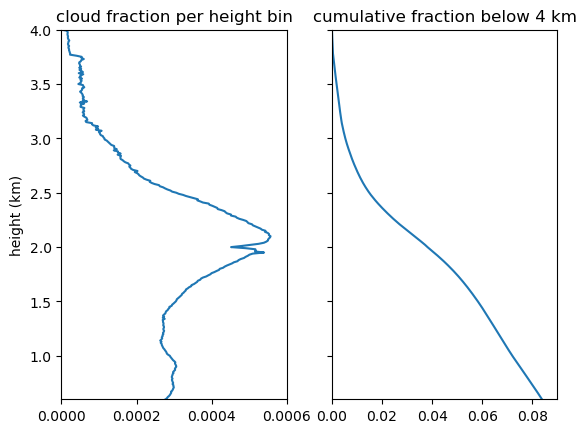

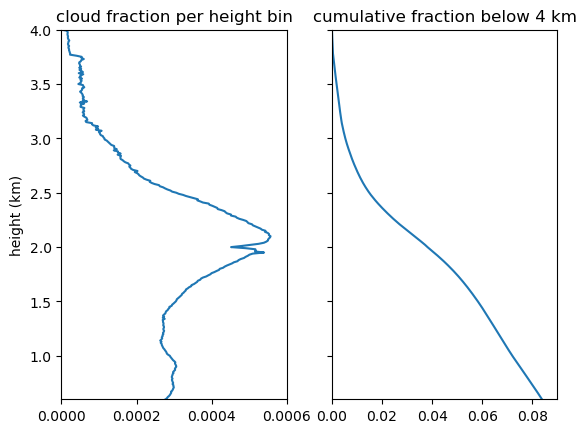

In [6]:
# plot mean cloud fraction vs. height data
rfv_nrm = mean(dsa[:rfv_nrm], dims=2)
rfv_acc = mean(dsa[:rfv_acc], dims=2)

fig, axs = subplots(1,2)

axs[1].plot(rfv_nrm, dsa[:cth_bin])
axs[1].set_title("cloud fraction per height bin")
axs[1].set_ylabel("height (km)")
axs[1].set_xlim([0, 6e-4])
axs[2].plot(rfv_acc, dsa[:cth_bin])
axs[2].set_xlim([0, 0.09])
axs[2].set_yticklabels((""))
axs[2].set_title("cumulative fraction below 4 km")
[ ax.set_ylim([0.6, 4]) for ax in axs ]
gcf()

# all( .≈(diff( dsa[:cth_bin][:] ), 0.01 ) ) # 10 m

In [7]:
"average all sounding times. preserve levels"
tmean(var, ds=ds) = [mean(skipmissing(ds[var][i,:])) for i in axes(ds[var][:,:],1)]

# get mean sounding data
z = ds[:alt][:]
tam = tmean(:ta) # K
thm = tmean(:theta)
qm  = tmean(:q)
pm  = tmean(:p) # Pa
qs  = qsat.(pm, tam.-KelvinCelsius) # kg/kg

tvm = tam .* (1 .+ 0.608*qm) # virtual temperature, K
#tdm = tvm # liqldfac(ql) # density temperature, K; no liquid water in env

3100-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 301.24035316388364
 301.12132369686776
 301.0095596774176
 300.9034356924022
 300.80359761428525
 300.7005503297537
 300.6019584969542
 300.49342623961616
 300.3915169658643
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

In [8]:
# large scale profile for cloud & flux model

# vertical grid
z = ds[:alt][:]
ii = findall(isfinite.(qm))

zi = 3.0e3    # m
ztop = 4e3
# cloud base initial condition
zcb = 700
icb = findfirst(z .>= zcb) # cloud base index
qcb = qs[icb] # 0.0157
#Δq = qs .- qm # depends on environment only # different in paper text!

# derivatives
dz = 10.0 # z[2] - z[1]
dqdz  = diff(tmean(:q)) / dz
dqsdz = diff( qs      ) / dz
qm = tmean(:q)
z = ds[:alt][:]
ii = findall(isfinite.(qm))

# total large scale drying, add advection term in lower atm
divg = 1.0e-6 # 1/s

"large scale subsidence vertical velocity (m/s)"
subsidence(z; divg=divg, zi=zi) = -min(z,zi) * divg # <0
wdqdz = subsidence.(z[1:end-1]) .* dqdz
# ^ negate on rhs

# large scale source
S_ls = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) 

# vertical means over the cloud layer
Tmean = mean(skipnan(tmean(:ta)[ds[:alt].<=ztop])) # 286.6K = mean Cu layer temperature
pmean = mean(skipnan(tmean(:p)[ds[:alt].<=ztop]))
L = Lv(Tmean)
rhoL = pmean/(Rd*Tmean) * L

#=
E0 = -mean(skipmissing(psl["hl_bulk"][:])) # 180 W/m^2
P0 = rhosfc*L * mean(skipmissing(psl["prate"][:])) / 3600 # -> 25 W/m^2
=#

2.426927036481407e6

In [9]:
# compute total all-sky flux G with cloud base BC

# cloud base vapor flux initial condition
Ecb = 145 # E0 - 35; just the cloud vapor flux
Gcb = Ecb/rhoL - mean(skipmissing(psl["prate"][:])) / 3600 # _total_ flux F at cloud base
# F[icb] = Fcb # total flux at cloud base
# integrate total flux balancing subsidence
G = similarmissing(qm)
# A = -wdqdz .- 1.7e-8*max.(0, (4e3.-z[1:end-1])/4e3) # as above
G[icb:end] = Gcb .+ vcat(0, cumsum( S_ls[icb:end] ) * dz)

# icb = findfirst(.!ismissing.(F))
itop=lastindex(G)-1 

3099

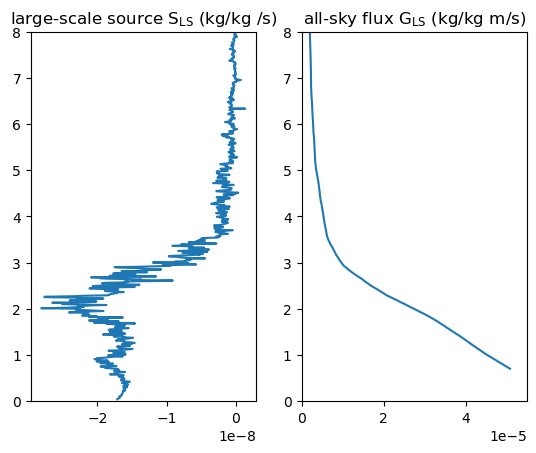

(0.0, 5.5e-5)

In [10]:
# plot G as a function of height
close("all")
subplot(1,2,1)
plot(S_ls, z[1:end-1]/1e3)
title("large-scale source S\$_\\text{LS}\$ (kg/kg /s)")
ylim([0, 8])

subplot(1,2,2)
plot(G, z/1e3)
title("all-sky flux G\$_\\text{LS}\$ (kg/kg m/s)")
ylim([0, 8])
xlim([0, 5.5e-5])
# gcf()


## cloud ensemble, heights and area fractions

### Method 1, Horizontally uniform cloud eddy flux:
We distribute the all-sky mean flux G to the all-cloud mean 
$F=a_{cld}^{-1} G$, and then *evenly* to each cloud. If each cloud at level z has the same mean flux F_i (z)=F(z), then the all sky flux is
$$
G(z)=∑F_i (z)[a_i H(h_i-z)]=F(z)∑[a_i H(h_i-z)]=a_{cld}(z)F_1(z)
$$
with total cloud fraction at height z of 
$a_{cld}(z)=∑[a_i H(h_i-z)]$ and Heaviside function $H(x)={1,x≥0;0,x<0}$. As the flux decreases with height, there are fewer clouds to carry the mean flux.

$F_i = F_1(z)$ does not depend on $i$.

Only count clouds with tops below height $z$, so $a_{cld}(z)$ decreases with height. 

So
$$
a_{cld}(z_k) = \sum_{i=1,k}a_i
$$

### Method 2, Vertically uniform cloud eddy flux: 
The all-sky mean flux profile $G(z)$ has a flux difference at each height $h_i$ of $(ΔG)_i=-[G(h_{i+1})-G(h_i)]$. This flux difference is assumed to be carried by the clouds with area fraction $a_i$ and height $h_i$, so the mean flux in cloud category $i$ is vertically uniform, 
$F_i=a_i^{-1} (ΔG)_i$.

This is the flux for each cloud category $i$. It is uniform from cloud base to $h_i$ and goes to zero above $h_i$.

### Method 1, Horizontally uniform cloud eddy flux

In [173]:
# calculate F1

# check cloud fraction
sum(rfv_nrm) ≈ maximum(rfv_acc) # true
# plot(rfv_acc, dsa[:cth_bin]) # decreases with height

# F1 = pd(G) ./ rfv_acc # dimension (category_i, z) ---WRONG---
# line up bins
offset = findfirst(x->x≈dsa[:cth_bin][1]*1e3, z) - 1 # 50
#test offset
z[offset] == dsa[:cth_bin][1]*1e3 # true; cth_bin starts at z=500


"""
calcF1(G, rfv_acc)
Horizontally uniform cloud eddy flux calcF1
We distribute the all-sky mean flux G to the all-cloud mean 
``F_1=a_{cld}^{-1} G``, and then *evenly* to each cloud. If each cloud at level z has the same mean flux F_i (z)=F(z), then the all sky flux is
```math
G(z)=∑F_i (z)[a_i H(h_i-z)]=F(z)∑[a_i H(h_i-z)]=a_{cld}(z)F_1(z)
```
with total cloud fraction at height z of 
``a_{cld}(z)=∑[a_i H(h_i-z)]`` 
and Heaviside function 
``H(x)={1,x≥0;0,x<0}``. 
As the flux decreases with height, there are fewer clouds to carry the mean flux.

``F_i = F_1(z)`` does not depend on ``i``.

Only count clouds with tops below height ``z``, so ``a_{cld}(z)`` 
decreases with height. 
So
```math
a_{cld}(z_k) = ∑_{i=1,k}a_i.
```
"""
function calcF1(G, rfv_acc)
    alignGi(G, rfv_acc) = G[offset.+eachindex(rfv_acc)]
    return alignGi(G, rfv_acc) ./ rfv_acc # dimension (z), does not depend on category_i
end

F1 = calcF1(G, rfv_acc)

# calculate F2

# ΔG = -diff(G) # z grid
# prototype
# F2 = -diff(G)[offset.+eachindex(rfv_nrm)] ./ rfv_nrm[:] # dimension category_i
# rfv_acc[end] == 0.0

calcF2_(G, acc; sk=1) = diff(G[1:sk:end]) ./ diff(acc[1:sk:end]) # dimension category_i, inputs asligned!

"""
calcF2(G, rfv_acc)
Vertically uniform cloud eddy flux 
The all-sky mean flux profile ``G(z)`` has a flux difference 
at each height ``h_i`` of ``(ΔG)_i=-[G(h_{i+1})-G(h_i)]``. 
This flux difference is assumed to be carried by the clouds with 
area fraction ``a_i`` and height 
``h_i``, so the mean flux in cloud category ``i`` is vertically uniform, 
``F_i=a_i^{-1} (ΔG)_i``.

This is the flux for each cloud category ``i``. It is uniform from cloud base to ``h_i`` and goes to zero above ``h_i``.
"""
function calcF2(G, rfv_acc; sk)
    align2i(G) = G[offset.+eachindex(rfv_acc)] # dimension category_
    return calcF2_(align2i(G), rfv_acc; sk=sk) # inputs not aligned
end

F2 = calcF2(G, rfv_acc; sk=1)

# coarsen bin size to 100 m
F2c = calcF2(G, rfv_acc; sk=10)
# mean not weighted by area
# F2m = mean(skipmissing(nisf2m.(F2)))
# mean weighted by area
F2m = sum( skipmissing(nisf2m.(F2) .* rfv_nrm[1:end-1]) ) / sum( rfv_nrm )
"The mean flux over all cloud categories i is $(round(F2m*1e3, digits=2)) g/kg m/s = $(round(F2m*rhoL, digits=0)) W/m²"

"The mean flux over all cloud categories i is 0.53 g/kg m/s = 1281.0 W/m²"

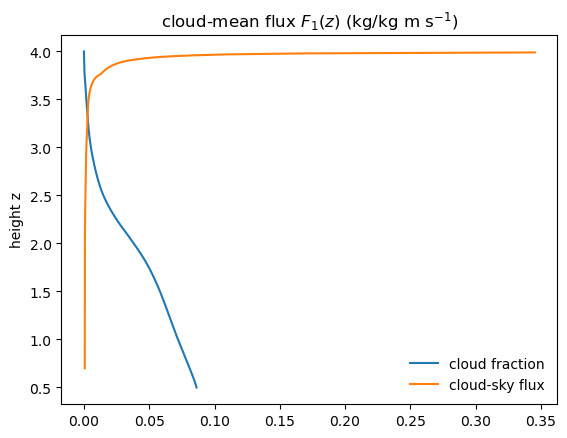

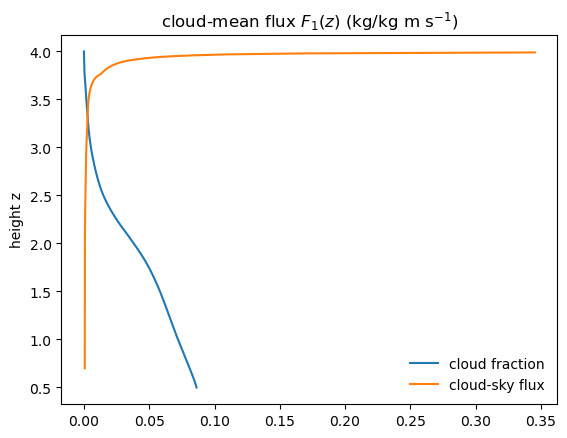

In [12]:
# plot F1
close("all")
fig, ax = subplots(1,1)
plot(rfv_acc, dsa[:cth_bin], label="cloud fraction")
plot(F1, dsa[:cth_bin], label="cloud-sky flux")
ylabel("height z")
# xlim([-0.0005, 0.35]); ylim([0, 4.01])
title("cloud-mean flux \$F_1(z)\$ (kg/kg m s\$^{-1}\$)")
legend(frameon=false)
gcf()


Almost all the flux is carried by the tallest clouds.

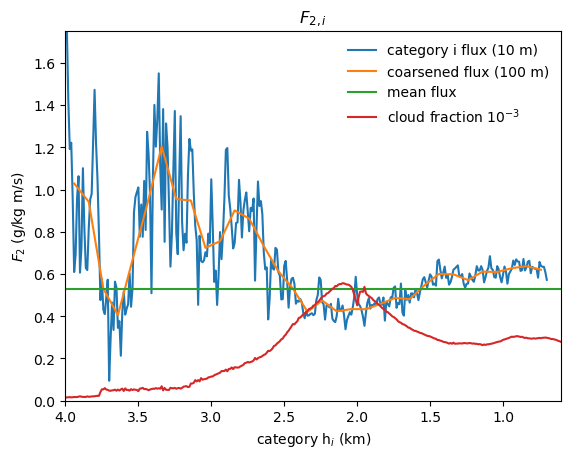

(4.0, 0.6)

In [170]:
# plot F2

close("all")
figure()
plot(vec(dsa[:cth_bin][eachindex(F2)]), 1e3*F2, label="category i flux (10 m)")
plot(vec(dsa[:cth_bin][5:10:end-1]), 1e3*F2c, label="coarsened flux (100 m)")
plot([0.6, 4], [1e3, 1e3].*F2m, label="mean flux")
plot(vec(dsa[:cth_bin][eachindex(F2)]), 1e3*rfv_nrm[eachindex(F2)], label="cloud fraction 10\$^{-3}\$")
title("\$F_{2,i}\$")
legend(frameon=false)
xlabel("category h\$_i\$ (km)")
ylabel("\$F_2\$ (g/kg m/s)")
ylim([0, 1.75])
xlim([4, 0.6])
# gcf()

## cloud model

In [14]:
# cloud model - updraft total water and cloud water functions
# Updraft q_total, ql do not depend on F or Fcld.
# Below, mass flux W depends on q_total and Fcld.

# define parameters that functions depend on
# entrainment, autoconversion, and precipitation efficiency
# ae = 1.5e-3
# x = 0.39
# entr_coeff = (1-x) * ae
# pcp_coeff = x * ae

"qtilde=(1-x)*qm .+ x*qs intermediate environmental moisture function"
function q_tilde(qm, qs, x)
    (1-x)*qm .+ x*qs
end

"updraft q_total function"
function q_total(aedz, x, qs, qm; i0, qt0, stopattop=false)
    qtilde=(1-x)*qm .+ x*qs
    qt = copy(qtilde)
    qt[1:i0] .= qt0 # cloud base initial condition
    # in cloud
    for i in i0:length(qt)-1
        if qt[i] > qs[i] # in cloud
            a = aedz
            Q = 0.5*(qtilde[i]+qtilde[i+1])
            qt[i+1] = ((1-0.5*a)*qt[i] + a*Q) / (1+0.5*a)
        elseif !stopattop   # above cloud
            a = (1-x)*aedz  # no precipitation sink
            Q = 0.5*(qm[i]+qm[i+1])
            qt[i+1] = ((1-0.5*a)*qt[i] + a*Q) / (1+0.5*a)
        elseif stopattop  # above cloud, stop at cloud top
            qt[i+1] = -999
        end
    end
    return qt
end

# cloud flux Fcld functions
# ql needs to be calculate by the cloud functions already
"""
Iterates up cloud flux modifying Fcld with precipitation efficiency x and total flux F.
Must initialize cloud base Fcld[icb] first!
"""
function cloudflux!(Fcld, x, ae, F, ql, qt, qm, icb=icb, itop=min(lastindex(F),findfirst(.!ismissing.(F) .&& F.<0)+20))
    Δq = qt .- qm
    c = @. -x*ae * ql / Δq * dz/2 # Q*dz stepping quantity # /2 added 2025 Aug 16
    # step Fcld through the trade Cu layer
    for i in icb:itop
        Fcld[i+1] = (F[i+1]-F[i] + Fcld[i]*(1+c[i])) / (1-c[i+1])                
    end
end

"integrate precipitation down to cloud base by stepping"
function precipflux_down_sfc(x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    #P[istart] = 0.0
    P = 0.0 # at cloud top istart
    for i in (istart-1):-1:icb
        # update P by 1 step
        # P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
        P = ( (1+c[i+1])*P + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    return P # at cloud base
end

"precipitation profile integrated downward from cloud top"
function precipflux_down(x, ae, F, ql, qt, qm; istart=maximum(findall(ql.>0))+1, icb=icb)
    c = @. x*ae * ql/(2*(qt-qm)) * dz
    #P[istart] = 0.0
    P = zeros(size(F)) # at cloud top istart
    for i in (istart-1):-1:icb
        # update P by 1 step
        P[i] = ( (1+c[i+1])*P[i+1] + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
      # P    = ( (1+c[i+1])*P      + c[i]*F[i] + c[i+1]*F[i+1] ) / ( 1-c[i] )
    end
    P[1:icb-1] = NaN
    return P # precip flux vector
end

precipflux_down

In [86]:
# align F2 to z grid
F2z = Array{Union{Missing, Float64}}(missing, size(qtilde))
F2z[offset.+eachindex(F2)] .= F2[:] 
# needs to be masked with 0 above cloud top
# plot(F2z)

350-element view(::Vector{Union{Missing, Float64}}, 51:400) with eltype Union{Missing, Float64}:
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
 ⋮
 0.0011009241464203377
 0.0007238582547835853
 0.0006063715556285217
 0.0010629755268997292
 0.0009595738806342757
 0.0006925058779419848
 0.0006092920947207968
 0.0009559308498293984
 0.0012216140909632558
 0.0011918325557094302
 0.0014210335099526768
 0.0017635346344911562

In [196]:
# test the precip computation

# set parameters
ae = 3e-3
x = 0.5
# cloud base initial condition
zcb = 700
icb = findfirst(z .>= zcb)
qcb = qs[icb] # 0.0157

# compute clouds
qtilde = q_tilde(qm, qs, x)
qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb)
itop = findlast(qt.-qs .> 0)
ql = max.(0, qt.-qs)

precipflux_down_sfc(x, ae, F2z, ql, qt, qm, istart=maximum(findall(ql.>0))+1, icb=icb) * rhoL
# W/m^2

59.18542427465439

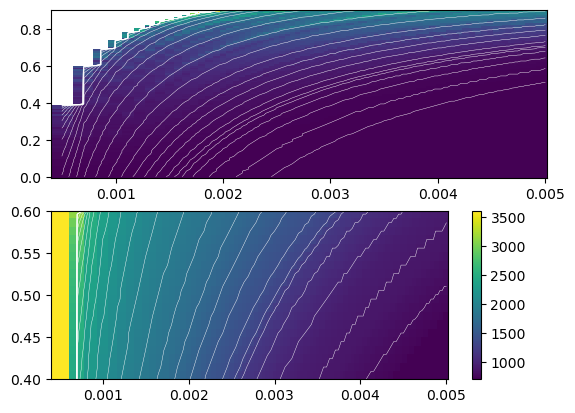

(0.4, 0.6)

In [197]:
# iterate cloud model for F2z_i

nz = length(z)
#cloud base and cloud top indices
ist = findfirst(z .>= 2000)
ien = findfirst(z .<= 5000)

"terminate the cloud at ql=0"
findcloudtop(ql) = findfirst(ql .== 0 .&& z .> zcb )

"terminate the cloud either at ql=0 or at the elevated minimum ql in the trade inversion"
function findcloudtop(ql, ist,ien)
    itop = findfirst(ql .== 0 .&& z .> zcb )
    if isnothing(itop) # choose the minimum 
        itop = argmin(ql[ist:ien]) + ist - 1
    end
    itop
end

Fcld = similarmissing(F2z)
# parameter ranges for experiments
nx = 90
ns = 100
pcp_effic = range(0, 0.9, length=nx) #0:0.005:0.9         # precipitation efficiency
tot_sink  = sqrt.(range(5e-4^2, 5e-3^2, length=ns)) # total sink rate α+ϵ
Pcb  = Matrix{Union{Missing,Float64}}(missing, nx, ns)
ztop = Matrix{Union{Missing,Float64}}(missing, nx, ns)

ff = Vector{Union{Missing, Float64}}(missing, nz)
for ix in eachindex(pcp_effic)
    qtilde = q_tilde(qm, qs, x)
    for ia in eachindex(tot_sink)
        x  = pcp_effic[ix]
        ae = tot_sink[ia]
        # compute clouds
        qt = q_total(dz*ae, x, qs, qm; i0=icb, qt0=qcb)
        ql = max.(0, qt.-qs)
        # itop = findlast(ql .> 0)
        itop = findcloudtop(ql)
        if !isnothing(itop)
            ztop[ix,ia] = z[itop]
            fill!(ff, F2z[itop]) # use the flux for the experiment cloud top height
            Pcb[ix,ia] = precipflux_down_sfc(x, ae, ff, ql, qt, qm, istart=itop, icb=icb)
        end
    end
end

# plot results
subplot(2,1,1)
pcolormesh(tot_sink, pcp_effic, Pcb)
contour(tot_sink, pcp_effic, ztop; colors="white", levels=500:100:3600, linewidths=0.3)
subplot(2,1,2)
pcolormesh(tot_sink, pcp_effic, ztop; vmax=3600)
colorbar()
contour(tot_sink, pcp_effic, ztop; colors="white", levels=500:100:3600, linewidths=0.3)
ylim([0.4, 0.6])
# texture is from F2(h_i).

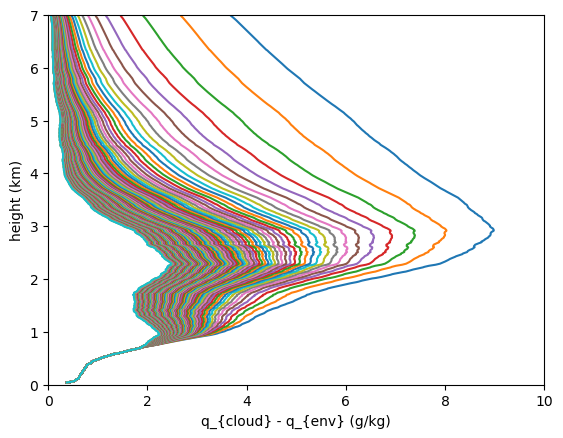

PyObject Text(0.5, 24.140625, 'q_{cloud} - q_{env} (g/kg)')

In [ ]:
# plot example qt-qm for one precip efficiency

Qt = stack([ q_total(dz*ae, 0.5, qs, qm; i0=icb, qt0=qcb) for ae in tot_sink ])

close("all")
# contour(tot_sink, z, Qt) # q ~ 1/ae
plot((Qt.-qm)*1e3, z/1e3) # q ~ 1/ae
ylim([0, 7])
xlim([0, 10])
ylabel("height (km)")
xlabel("q_{cloud} - q_{env} (g/kg)")

In [ ]:
# cloud top height computed within 10 m
itop_ens = @. floor(Int32, ztop/10 - offset) + 1
cth = map( i -> i<=351 ? dsa[:cth_bin][i] : missing, itop_ens )
cth - ztop/1e3 # should be small differences
a_i = map( i -> i<=351 ? rfv_nrm[i] : 0, itop_ens ) # cloud area fractions _i (matrix)
# all sky mean precip by clouds below ~4 km
Pcb_tot = sum(x->ismissing(x) ? 0 : x, Pcb .* a_i, dims=2) # multiple counts some bins


181×1 Matrix{Union{Missing, Float64}}:
 0.0
 6.818852691063309e-9
 1.3754327740330832e-8
 2.07714200473369e-8
 2.8095263848196647e-8
 3.535685795047382e-8
 4.3036690243157984e-8
 5.125588053156349e-8
 5.919061553342409e-8
 6.74084771708974e-8
 7.539965258272834e-8
 8.365575319761409e-8
 9.275472092301777e-8
 ⋮
 1.8499270699015965e-5
 1.887605456362247e-5
 1.9452002398901894e-5
 1.9919658891299055e-5
 2.0418869639252544e-5
 2.0903296188631485e-5
 2.1321307519306943e-5
 2.1825668164730265e-5
 2.2149894681031125e-5
 2.256204886007014e-5
 2.300887854084812e-5
 2.3147149501257728e-5

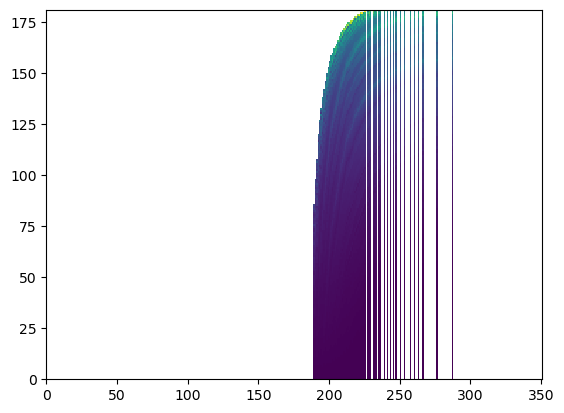

PyObject <matplotlib.collections.QuadMesh object at 0x3bfa756f0>

In [ ]:
# avoid double counting precip in repeated bins
Pcb_bin = zeros(size(itop_ens,1), length(rfv_nrm))
count_bin = zeros(size(itop_ens,1), length(rfv_nrm))
a_bin = similar(Pcb_bin)

for idx in CartesianIndices(itop_ens)
    (kx, ks) = Tuple(idx)
    i = itop_ens[ks] # height bin index
    if ( !ismissing(i) 
        && i <= length(rfv_nrm) 
        && !ismissing(Pcb[kx, ks]) 
        && !ismissing(a_i[kx, ks]) )

        Pcb_bin[kx, i] += Pcb[kx, ks] # add contribution from cloud top bin
        count_bin[kx, i] += 1
        a_bin[kx, i] = a_i[kx, ks]
    end
end
# pcolormesh(Pcb_bin./count_bin)
Pcb_tot_nodouble = sum(Pcb_bin./count_bin, dims=2)

In [ ]:

# now sum Pcb_bin
Pcb_tot1 = sum(x-> !isfinite(x) ? 0 : x, Pcb_bin .* a_bin, dims=2)
plot(pcp_effic, Pcb_tot1*rhoL)

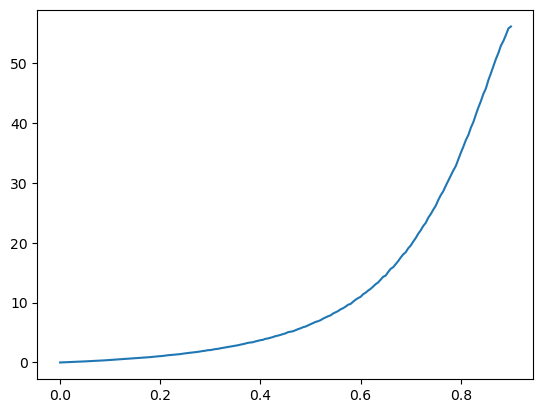

1-element Vector{PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x3bf291e10>

In [135]:

close("all")
# pcolormesh(tot_sink, pcp_effic, Pcb*rhoL)
plot(pcp_effic, Pcb_tot*rhoL)
# colorbar()
# plot(pcp_effic, Pcb_tot*rhoL)

In [127]:
a_i

181×181 Matrix{Real}:
 0.000393751  0.000434201  0.000451453  …  0.000299306  0.000299306
 0.000393751  0.000426266  0.000451453     0.000299306  0.000299306
 0.000392319  0.000426266  0.000450901     0.000299306  0.000299306
 0.000392319  0.000415985  0.000450901     0.000299306  0.000299306
 0.000376597  0.000415985  0.000450901     0.000299306  0.000299306
 0.000376597  0.000414733  0.000440971  …  0.000299306  0.000299306
 0.000369704  0.000414733  0.000440971     0.000299306  0.000299306
 0.000369704  0.000414733  0.000437019     0.000299306  0.000299306
 0.000369704  0.00040833   0.000437019     0.000299306  0.000299306
 0.00036164   0.00040833   0.000437019     0.000299306  0.000299306
 0.00036164   0.000401528  0.000434201  …  0.000299306  0.000299306
 0.000363157  0.000401528  0.000434201     0.000299306  0.000299306
 0.000363157  0.000393751  0.000426266     0.000299306  0.000299306
 ⋮                                      ⋱               ⋮
 0            0            0        